In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras

print(tf.__version__)

2.3.0


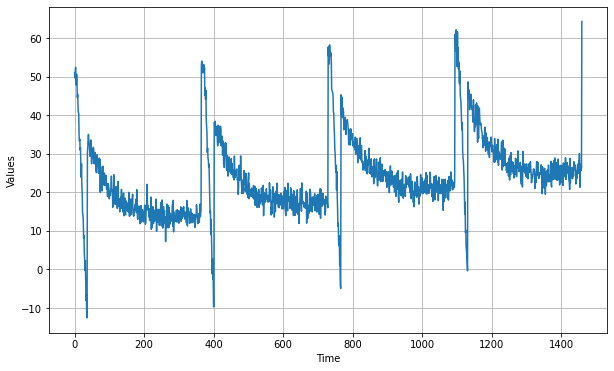

In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end],series[start:end],format)
    plt.xlabel("Time")
    plt.ylabel("Values")
    plt.grid(True)

def trend(time,slope=0):
    return time * slope

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.1,
                    np.cos(season_time * 7 * np.pi),
                    1 / np.exp(5 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
amplitude = 40
slope = 0.01
noise_level = 2

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

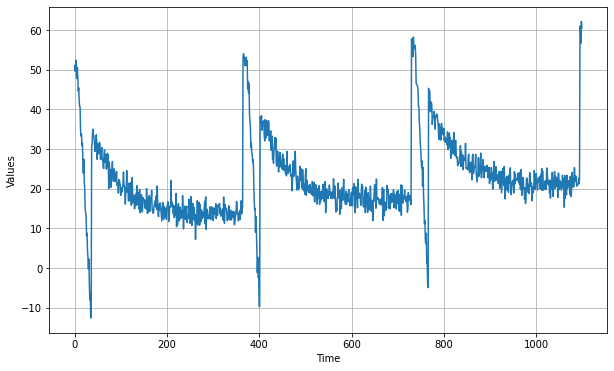

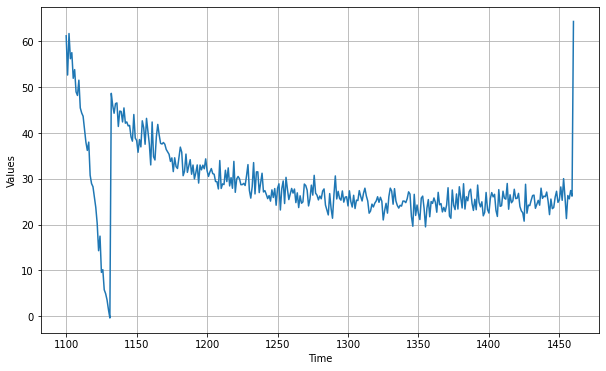

In [3]:
split = 1100
time_train = time[:split]
x_train = series[:split]
time_valid = time[split:]
x_valid = series[split:]

# Plotting the training data
plt.figure(figsize=(10,6))
plot_series(time_train, x_train)
plt.show()

# Plotting the validation data
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plt.show()


## Naive forecast

In [4]:
naive_forecast = series[split-1:-1]

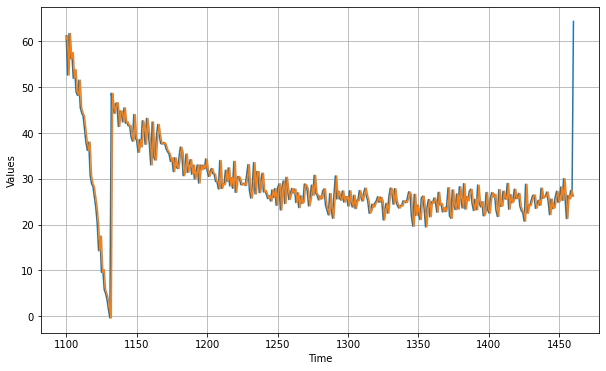

In [5]:
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)
plt.show()

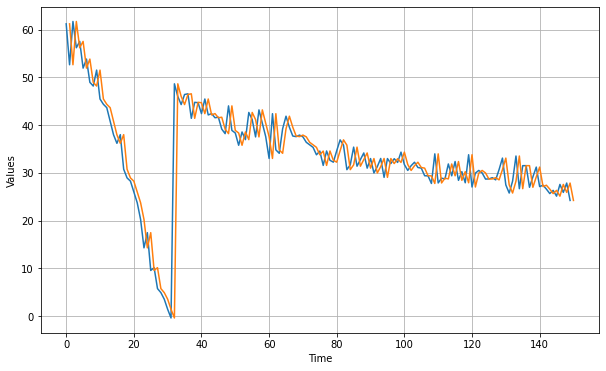

In [6]:
# Let's zoooom in a little bit
plt.figure(figsize=(10,6))
plot_series(time_train, x_valid, start=0, end=150)
plot_series(time_train, naive_forecast, start=1, end=151)

plt.show()

In [7]:
def moving_average_forecast(series, window_size):
    forecast = []
    for time in range(len(series) - window_size):
        forecast.append(series[time:time + window_size].mean())
    return np.array(forecast)

In [8]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

19.578304
2.6011972


#Moving Average

In [9]:
moving_average = moving_average_forecast(series, window_size=30)

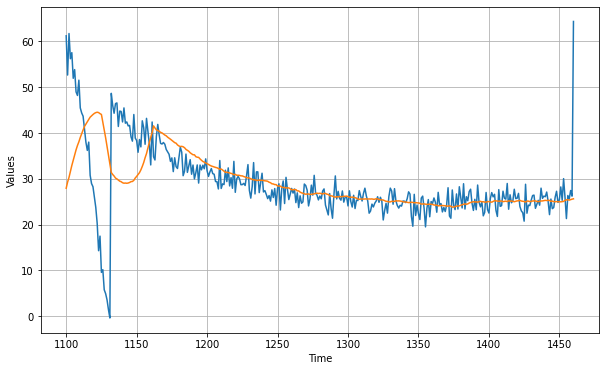

In [10]:
moving_average = moving_average[split-30:]
plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_average)
plt.show()

In [11]:
print(keras.metrics.mean_squared_error(x_valid, moving_average).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_average).numpy())

65.78622
4.3040023


##Differencing

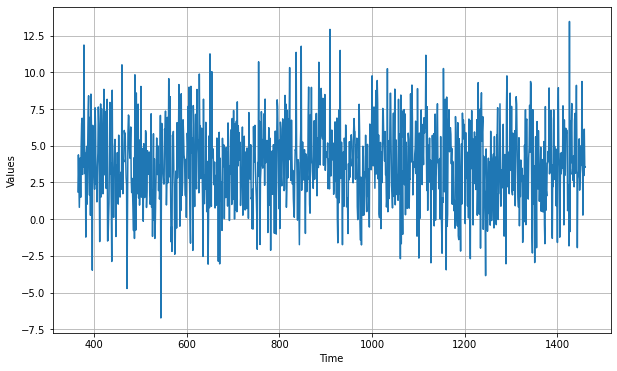

In [12]:
diff_series = series[365:] - series[:-365]
diff_time = time[365:]

plt.figure(figsize=(10,6))
plot_series(diff_time, diff_series)
plt.show()

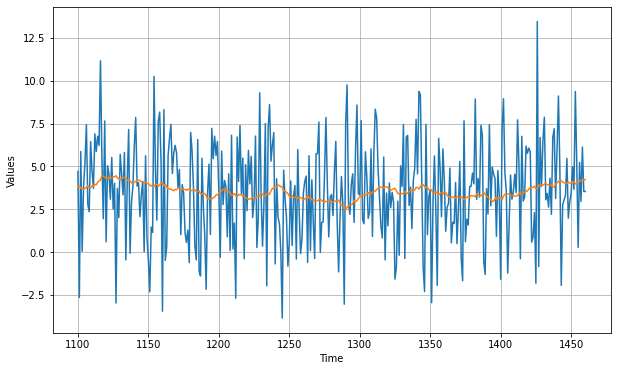

In [13]:
diff_moving_average = moving_average_forecast(diff_series, window_size=50)
diff_moving_average = diff_moving_average[split-365-50:]

plt.figure(figsize=(10,6))
plot_series(time_valid, diff_series[split-365:])
plot_series(time_valid, diff_moving_average)
plt.show()

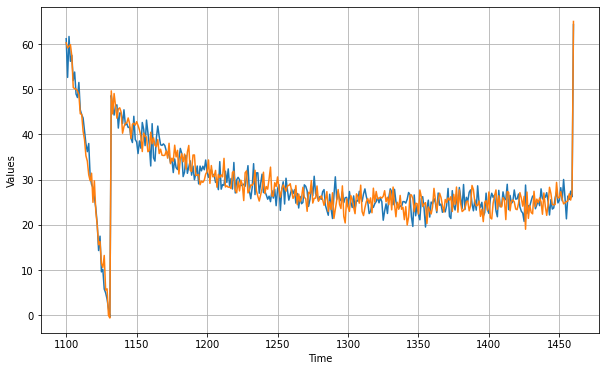

In [15]:
diff_moving_avg_plus_past = diff_moving_average + series[split-365:-365]

plt.figure(figsize=(10,6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [16]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

8.498155
2.327179


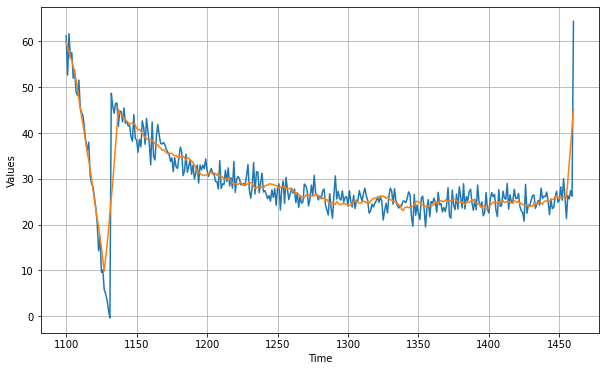

In [20]:
diff_moving_avg_plus_smooth_past = diff_moving_average + moving_average_forecast(series[split - 370:-360], 10)

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [21]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

12.527958
2.2034435
